# LayoutLMv3 Invoice Extraction Inference Notebook

This notebook demonstrates how to use a trained LayoutLMv3 model to extract key fields (invoice number, date, amount) from invoice images. It supports both single-image and batch inference on the test set.

---

**Sections:**
1. Import Required Libraries
2. Load Trained Model and Processor
3. Select or Randomly Choose an Image for Inference
4. Run OCR on the Selected Image
5. Preprocess Image and OCR Output for Model Input
6. Visualize OCR Tokens on the Image
7. Run Inference and Extract Predicted Labels
8. Display Extracted Fields (Invoice Number, Date, Amount)
9. Visualize Predicted Labels on the Image
10. Batch Inference on Test Dataset and Convert Results


In [1]:
# 1. Import Required Libraries
import os
import random
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Processor
from datasets import load_dataset
import torch

# PaddleOCR (GPU) import
from paddleocr import PaddleOCR

# For file selection UI (Jupyter only)
try:
    from ipywidgets import FileUpload, Dropdown, Button, Output, VBox, HBox
    from IPython.display import display, clear_output
    ipywidgets_available = True
except ImportError:
    ipywidgets_available = False

# Utility for field extraction
import re


## 2. Load Trained Model and Processor
Load the trained LayoutLMv3 model and processor for inference. Make sure the model directory exists and contains the necessary files.

In [3]:
# 2. Load Trained Model and Processor
MODEL_DIR = "./model/layoutlmv3-invoice"
assert os.path.exists(MODEL_DIR), f"Model directory not found: {MODEL_DIR}"

processor = LayoutLMv3Processor.from_pretrained(MODEL_DIR)
model = LayoutLMv3ForTokenClassification.from_pretrained(MODEL_DIR)
model.eval()

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded on device: {device}")

Model loaded on device: cuda


## 3. Select or Randomly Choose an Image for Inference
You can select an image file for inference, or let the notebook randomly pick one from the test set directory.

In [ ]:
# 3. Select or Randomly Choose an Image for Inference

test_img_dir = "../dataset/test"  # Adjust if your test images are elsewhere
img_extensions = [".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"]

def list_images(directory):
    return [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in img_extensions]

selected_image_filename = None
if ipywidgets_available and os.path.exists(test_img_dir):
    images = list_images(test_img_dir)
    if images:
        dropdown = Dropdown(options=images, description="Test Image:")
        button = Button(description="Load Selected Image")
        out = Output()
        def on_button_clicked(b):
            global selected_image_filename
            with out:
                clear_output()
                selected_image_filename = dropdown.value
                print(f"Selected: {selected_image_filename}")
        button.on_click(on_button_clicked)
        display(VBox([dropdown, button, out]))
    else:
        print(f"No images found in {test_img_dir}")
else:
    print("Widget selection unavailable. Use the next cell to pick a random image.")

In [16]:
# Run this cell after selecting an image above
if ipywidgets_available and os.path.exists(test_img_dir):
    if 'selected_image_filename' in globals() and selected_image_filename:
        image_path = os.path.join(test_img_dir, selected_image_filename)
        print(f"Using image: {image_path}")
    else:
        # Fallback to random if nothing selected
        images = list_images(test_img_dir)
        if images:
            image_path = os.path.join(test_img_dir, random.choice(images))
            print(f"No image selected, using random image: {image_path}")
        else:
            raise RuntimeError(f"No images found in {test_img_dir}")
else:
    # Fallback: pick a random image from test set
    if os.path.exists(test_img_dir):
        images = list_images(test_img_dir)
        if images:
            image_path = os.path.join(test_img_dir, random.choice(images))
            print(f"Randomly selected image: {os.path.basename(image_path)}")
        else:
            raise RuntimeError(f"No images found in {test_img_dir}")
    else:
        raise RuntimeError(f"Test image directory not found: {test_img_dir}")

assert image_path is not None, "No image selected or found for inference."

Using image: ../dataset/test\114_jpg.rf.b8f0927250780fe5a9178f369f5b82d7.jpg


## 4. Run OCR on the Selected Image
Apply PaddleOCR (GPU) to extract words and bounding boxes from the selected image.

In [17]:
# 4. Run OCR on the Selected Image
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=False)

ocr_result = ocr.ocr(image_path, cls=True)

# Flatten results (PaddleOCR returns a list of lists)
ocr_words = []
ocr_bboxes = []
for line in ocr_result[0]:
    bbox = line[0]
    text = line[1][0]
    ocr_words.append(text)
    # bbox: [[x0, y0], [x1, y1], [x2, y2], [x3, y3]]
    # Convert to [x0, y0, x2, y2] (top-left, bottom-right)
    x0, y0 = bbox[0]
    x2, y2 = bbox[2]
    ocr_bboxes.append([x0, y0, x2, y2])

print(f"Extracted {len(ocr_words)} words from OCR.")

[2025/06/30 09:18:48] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\Haythem/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\Haythem/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text

## 5. Preprocess Image and OCR Output for Model Input
Convert OCR tokens and bounding boxes into the format required by the LayoutLMv3 processor, including normalization and padding.

In [18]:
# 5. Preprocess Image and OCR Output for Model Input
# Load image
image = Image.open(image_path).convert("RGB")
width, height = image.size

# Normalize bboxes to 0-1000 as required by LayoutLMv3
norm_bboxes = []
for bbox in ocr_bboxes:
    x0, y0, x2, y2 = bbox
    x0 = int(1000 * x0 / width)
    y0 = int(1000 * y0 / height)
    x2 = int(1000 * x2 / width)
    y2 = int(1000 * y2 / height)
    norm_bboxes.append([x0, y0, x2, y2])

# Prepare processor input
encoding = processor(
    text=ocr_words,
    boxes=norm_bboxes,
    images=image,
    return_tensors="pt",
    truncation=True,
    padding="max_length",
    max_length=512
)
for k in encoding:
    encoding[k] = encoding[k].to(device)

print(f"Prepared input for model: {len(ocr_words)} tokens, {len(norm_bboxes)} bboxes.")

Prepared input for model: 64 tokens, 64 bboxes.


## 6. Visualize OCR Tokens on the Image
Plot the image with bounding boxes and text for each OCR token using matplotlib.

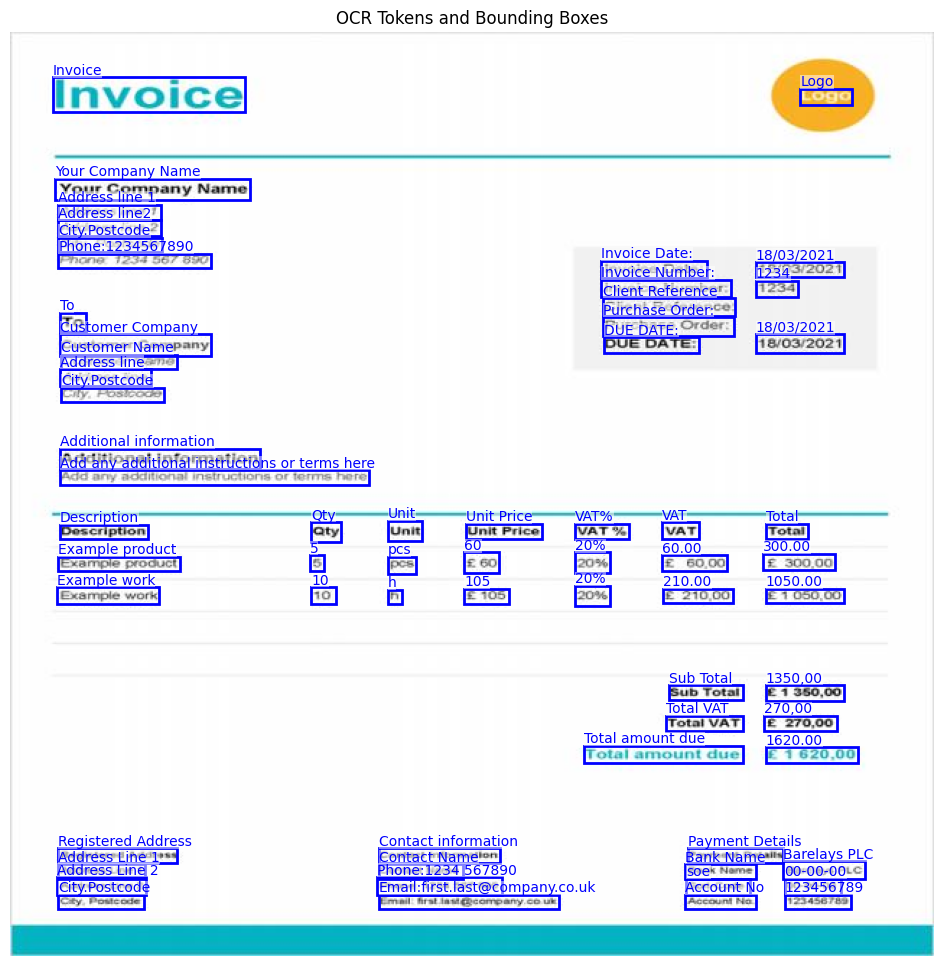

In [19]:
# 6. Visualize OCR Tokens on the Image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image)
for word, bbox in zip(ocr_words, ocr_bboxes):
    x0, y0, x2, y2 = bbox
    rect = patches.Rectangle((x0, y0), x2 - x0, y2 - y0, linewidth=2, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    ax.text(x0, y0 - 2, word, fontsize=10, color='blue', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0))
plt.title("OCR Tokens and Bounding Boxes")
plt.axis('off')
plt.show()

## 7. Run Inference and Extract Predicted Labels
Feed the preprocessed inputs into the model, obtain predictions, and map predicted IDs to label names.

In [20]:
# 7. Run Inference and Extract Predicted Labels
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits.cpu().numpy()[0]
    pred_ids = np.argmax(logits, axis=-1)

# Get label list from model config
id2label = model.config.id2label if hasattr(model.config, 'id2label') else {i: str(i) for i in range(model.config.num_labels)}
pred_labels = [id2label[str(i)] if str(i) in id2label else id2label[i] for i in pred_ids]

# Only keep predictions for actual tokens (not padding)
actual_len = len(ocr_words)
pred_labels = pred_labels[:actual_len]
print(f"Predicted labels for {actual_len} tokens:")
for word, label in zip(ocr_words, pred_labels):
    print(f"{word:20s} -> {label}")

Predicted labels for 64 tokens:
Invoice              -> O
Logo                 -> O
Your Company Name    -> O
Address line 1       -> O
Address line2        -> O
City.Postcode        -> O
Phone:1234567890     -> O
Invoice Date:        -> O
18/03/2021           -> O
Invoice Number:      -> O
1234                 -> O
Client Reference     -> O
To                   -> O
Purchase Order:      -> O
Customer Company     -> O
DUE DATE:            -> O
18/03/2021           -> O
Customer Name        -> O
Address line         -> O
City.Postcode        -> O
Additional information -> O
Add any additional instructions or terms here -> O
Description          -> O
Qty                  -> O
Unit                 -> O
Unit Price           -> O
VAT%                 -> O
VAT                  -> O
Total                -> O
Example product      -> O
5                    -> O
pcs                  -> O
60                   -> O
20%                  -> O
60.00                -> O
300.00               -> O
Examp

## 8. Display Extracted Fields (Invoice Number, Date, Amount)
Parse the predicted labels to extract the values for invoice number, date, and amount, and display them in a list.

In [21]:
# 8. Display Extracted Fields (Invoice Number, Date, Amount)
def extract_field(tokens, labels, field_name):
    # Extracts contiguous tokens with B- and I- tags for the given field
    field_tokens = []
    capture = False
    for token, label in zip(tokens, labels):
        if label == f"B-{field_name}":
            if field_tokens:
                break  # Only take the first occurrence
            field_tokens = [token]
            capture = True
        elif label == f"I-{field_name}" and capture:
            field_tokens.append(token)
        elif label.startswith("B-") and capture:
            break
        else:
            if capture:
                break
    return " ".join(field_tokens) if field_tokens else None

fields = ["InvoiceNumber", "Date", "Amount"]
results = {}
for field in fields:
    value = extract_field(ocr_words, pred_labels, field)
    results[field] = value

print("\nExtracted Fields:")
for k, v in results.items():
    print(f"{k}: {v}")


Extracted Fields:
InvoiceNumber: None
Date: None
Amount: None


## 9. Visualize Predicted Labels on the Image
Plot the image again, highlighting the tokens corresponding to the extracted fields (invoice number, date, amount) in different colors.

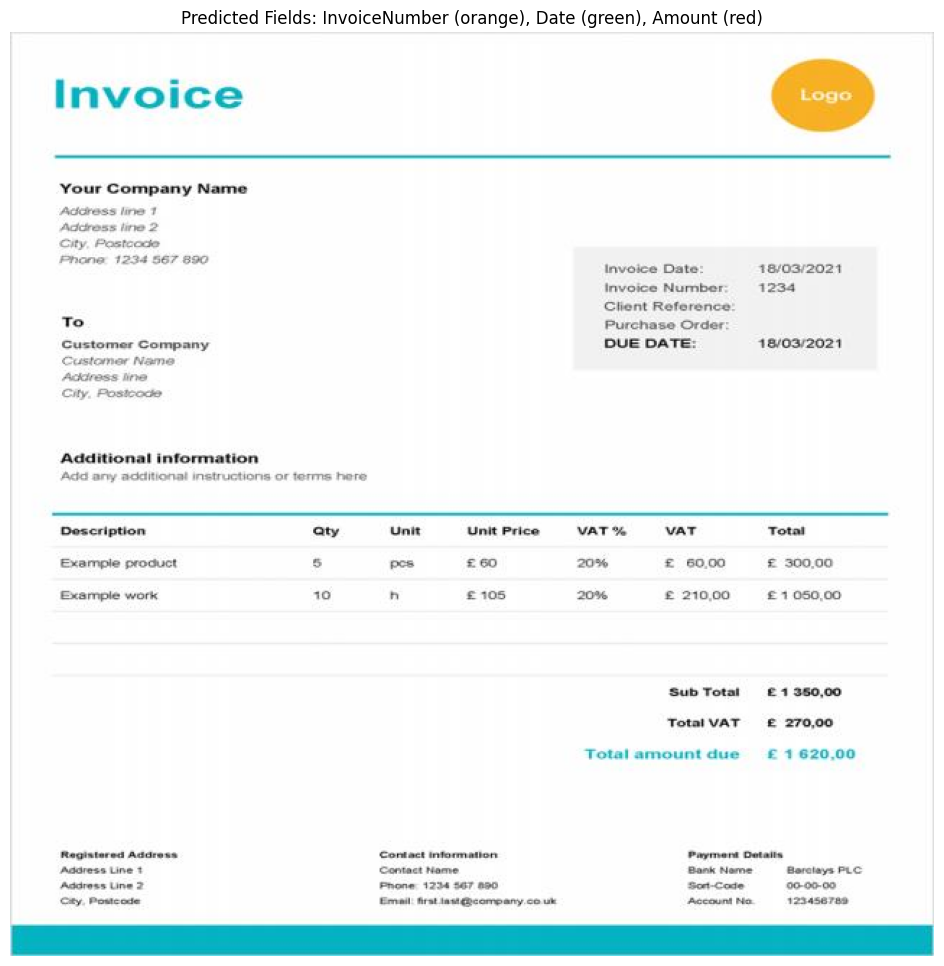

In [22]:
# 9. Visualize Predicted Labels on the Image
field_colors = {"InvoiceNumber": "orange", "Date": "green", "Amount": "red"}
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image)
for idx, (word, bbox, label) in enumerate(zip(ocr_words, ocr_bboxes, pred_labels)):
    for field, color in field_colors.items():
        if label.startswith(f"B-{field}") or label.startswith(f"I-{field}"):
            x0, y0, x2, y2 = bbox
            rect = patches.Rectangle((x0, y0), x2 - x0, y2 - y0, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x0, y0 - 2, word, fontsize=10, color=color, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0))
plt.title("Predicted Fields: InvoiceNumber (orange), Date (green), Amount (red)")
plt.axis('off')
plt.show()

## 10. Batch Inference on Test Dataset and Convert Results
Run inference on all images in the test dataset (layoutlmv3_test), convert and save the results in the desired output format.

In [ ]:
# 10. Batch Inference on Test Dataset and Convert Results
# Assumes test set is in '../layoutlmv3_test.jsonl' and images in '../dataset/test/'
test_jsonl = "../layoutlmv3_test.jsonl"
test_img_dir = "../dataset/test"
output_jsonl = "../layoutlmv3_test_infer_results.jsonl"

if os.path.exists(test_jsonl):
    with open(test_jsonl, "r", encoding="utf-8") as f:
        test_examples = [json.loads(line) for line in f]
    print(f"Loaded {len(test_examples)} test examples.")
    results = []
    for ex in test_examples:
        img_filename = ex.get("file_name") or ex.get("image_path")
        img_path = os.path.join(test_img_dir, img_filename)
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
        # OCR
        ocr_result = ocr.ocr(img_path, cls=True)
        ocr_words = []
        ocr_bboxes = []
        for line in ocr_result[0]:
            bbox = line[0]
            text = line[1][0]
            ocr_words.append(text)
            x0, y0 = bbox[0]
            x2, y2 = bbox[2]
            ocr_bboxes.append([x0, y0, x2, y2])
        # Normalize bboxes
        image = Image.open(img_path).convert("RGB")
        width, height = image.size
        norm_bboxes = []
        for bbox in ocr_bboxes:
            x0, y0, x2, y2 = bbox
            x0 = int(1000 * x0 / width)
            y0 = int(1000 * y0 / height)
            x2 = int(1000 * x2 / width)
            y2 = int(1000 * y2 / height)
            norm_bboxes.append([x0, y0, x2, y2])
        # Model input
        encoding = processor(
            ocr_words,
            boxes=norm_bboxes,
            images=image,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=512
        )
        for k in encoding:
            encoding[k] = encoding[k].to(device)
        # Inference
        with torch.no_grad():
            outputs = model(**encoding)
            logits = outputs.logits.cpu().numpy()[0]
            pred_ids = np.argmax(logits, axis=-1)
        id2label = model.config.id2label if hasattr(model.config, 'id2label') else {i: str(i) for i in range(model.config.num_labels)}
        pred_labels = [id2label[str(i)] if str(i) in id2label else id2label[i] for i in pred_ids]
        actual_len = len(ocr_words)
        pred_labels = pred_labels[:actual_len]
        # Extract fields
        fields = ["InvoiceNumber", "Date", "Amount"]
        result_fields = {}
        for field in fields:
            value = extract_field(ocr_words, pred_labels, field)
            result_fields[field] = value
        results.append({
            "file_name": img_filename,
            **result_fields
        })
    # Save results
    with open(output_jsonl, "w", encoding="utf-8") as f:
        for r in results:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")
    print(f"Batch inference complete. Results saved to {output_jsonl}")
else:
    print(f"Test JSONL not found: {test_jsonl}")